# SageMaker distributed data parallel and SageMaker Debugger example for Tensorflow

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Dataset](#Dataset)
    1. [Process the Data (Optional)](#Process-the-Data-(Optional))
    2. [Preview The Data](#Preview-The-Data)
5. [Build A Distributed Training Job](#Build-A-Distributed-Training-Job)
    1. [Preview the Training script](#Preview-the-Training-script)
    2. [Configure SageMaker Debugger rules](#Configure-SageMaker-Debugger-rules)
    3. [Configure & Run Training Estimator](#Configure-&-Run-Training-Estimator)
6. [Analyze Debugger Output](#Analyze-Debugger-in-SageMaker-Studio)
7. [Next steps & Clean Up](#Next-steps-&-Clean-Up)

## Introduction
This lab cover advance training topics like debugging and distributed training. At the end of this lab, you will get exposure to SageMaker services like SageMaker debugger and Amazon SageMaker's distributed library. [SageMaker debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) allows you to attach a debug process to your training job. This helps you monitor your training at a much granualar time interval and automatically profiling the instance to help you identify performance bottlenecks.

While [Amazon SageMaker's distributed library](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html) helps you train deep learning models faster and cheaper. The [data parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel.html) feature in this library is a distributed data parallel training framework for PyTorch, TensorFlow, and MXNet. This is a Tensorflow example using the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset.

**NOTE:** This example requires SageMaker Python SDK v2.X. and using Data Science Kernel

## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

- Access to the SageMaker default S3 bucket.
- Solid understanding of AWS Sagemaker and how to training deep learning models.
- Familiarity with Python and numpy
- Familiarity with Tensorflow deep learning framework and distributed training concepts
- Basic familiarity with AWS S3.
- Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.
- SageMaker Studio is preferred for the full UI integration

## Setup

Setting up the environment, load the libraries, and define the parameter for the entire notebook.

Run the cell below if you are missing smdebug and tensorflow module for your kernel

In [ ]:
!pip install smdebug
!pip install tensorflow

## Import modules and initialize parameters for this notebook

In [14]:
import sagemaker
from sagemaker import get_execution_role
import time
import logging
import boto3

role = get_execution_role()
sess = sagemaker.Session()

default_bucket = sess.default_bucket() # or use your own custom bucket name
base_job_prefix = 'bird-tf-sdp-debugger'
region_name = sagemaker.Session().boto_region_name

In [15]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

from sagemaker.debugger import (ProfilerConfig,
                                FrameworkProfile,
                                CollectionConfig,
                                DebuggerHookConfig,
                                DetailedProfilingConfig, 
                                DataloaderProfilingConfig, 
                                PythonProfilingConfig,
                                Rule,
                                PythonProfiler,
                                cProfileTimer,
                                ProfilerRule,
                                rule_configs)

from sagemaker.inputs import TrainingInput

## Dataset
The dataset we are using is from [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found here). Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels. Bounding boxes are provided, as are annotations of bird parts. A recommended train/test split is given, but image size data is not.

## Process the Data (Optional)
If you kept the data from module 2, you can skip to [next section](#Preview-Input-Data).  Otherwise run the code block below to process the data again. This is a repeat of module 2.

Run the cell below to download the full dataset or download manually [here](https://course.fast.ai/datasets). Note that the file size is around 1.2 GB, and can take a while to download. If you plan to complete the entire workshop, please keep the file to avoid re-download and re-process the data.

In [ ]:
!wget 'https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz'
!tar xopf CUB_200_2011.tgz
!rm CUB_200_2011.tgz

s3_raw_data = f's3://{default_bucket}/{base_job_prefix}/full/data'
!aws s3 cp --recursive ./CUB_200_2011 $s3_raw_data

In [17]:
from sagemaker.sklearn.processing import SKLearnProcessor

from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
)
import time 

timpstamp = str(time.time()).split('.')[0]
# SKlearnProcessor for preprocessing
output_prefix = f'{base_job_prefix}/outputs/{timpstamp}'
output_s3_uri = f's3://{default_bucket}/{output_prefix}'

class_selection = '13, 17, 35, 36, 47, 68, 73, 87'
input_annotation = 'classes.txt'
processing_instance_type = "ml.m5.xlarge"
processing_instance_count = 1

sklearn_processor = SKLearnProcessor(base_job_name = f"{base_job_prefix}-preprocess",  # choose any name
                                    framework_version='0.20.0',
                                    role=role,
                                    instance_type=processing_instance_type,
                                    instance_count=processing_instance_count)

In [19]:
sklearn_processor.run(
    code='../../02_preprocessing/preprocessing.py',
    arguments=["--classes", class_selection, 
               "--input-data", input_annotation],
    inputs=[ProcessingInput(source=s3_raw_data, 
            destination="/opt/ml/processing/input")],
    outputs=[
            ProcessingOutput(source="/opt/ml/processing/output/train", destination = output_s3_uri +'/train'),
            ProcessingOutput(source="/opt/ml/processing/output/valid", destination = output_s3_uri +'/valid'),
            ProcessingOutput(source="/opt/ml/processing/output/test", destination = output_s3_uri +'/test'),
            ProcessingOutput(source="/opt/ml/processing/output/manifest", destination = output_s3_uri +'/manifest'),
        ],
    )


Job Name:  bird-tf-sdp-debugger-preprocess-2022-03-25-21-58-57-681
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-987720697751/bird-tf-sdp-debugger/full/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-987720697751/bird-tf-sdp-debugger-preprocess-2022-03-25-21-58-57-681/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output-1', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-987720697751/bird-tf-sdp-debugger/outputs/1648245231/train', 'LocalPath': '/opt/ml/processing/output/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputNam

## Preview The Data

If you use the data generated from previous module, please update the s3 location of the data in the cell below.

In [20]:
s3_train = output_s3_uri +'/train'
s3_valid = output_s3_uri +'/valid'
print(s3_train)

s3://sagemaker-us-west-2-987720697751/bird-tf-sdp-debugger/outputs/1648245231/train


Copy the data locally

In [ ]:
!aws s3 cp $s3_valid ./data/valid --recursive

Found 95 images belonging to 8 classes.
(16, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 0. 1.]


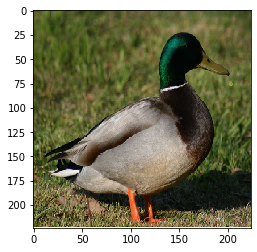

(16, 224, 224, 3)
[0. 0. 0. 1. 0. 0. 0. 0.]


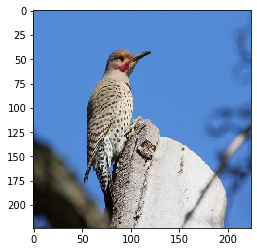

(16, 224, 224, 3)
[0. 0. 1. 0. 0. 0. 0. 0.]


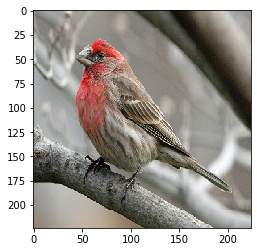

(16, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 0. 1.]


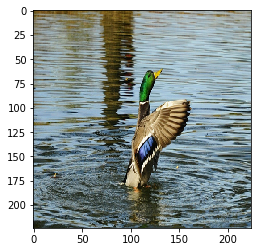

(16, 224, 224, 3)
[0. 0. 0. 0. 1. 0. 0. 0.]


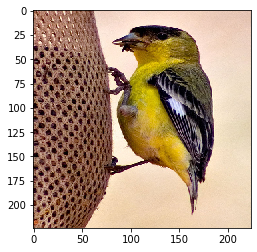

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

import matplotlib.pyplot as plt

import IPython.display as display 

from io import StringIO

val_datagen  = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory('./data/valid',
                                              target_size=(224, 224), 
                                              batch_size=16)


for _ in range(5):
    img, label = val_gen.next()
    print(img.shape)   #  (1,256,256,3)
    print(label[0])
    plt.imshow(img[0])
    plt.show()

## Build A Distributed Training Job

### Preview the Training script

The training script provides the code you need for distributed data parallel training using SageMaker's distributed data parallel library (`smdistributed.dataparallel`). The training script is very similar to a Tensorflow training script you might run outside of SageMaker using Horovod, but modified to run with the `smdistributed.dataparallel` library. This library's Tensorflow client provides an alternative to Horovod and is optimized for AWS infrastructure. 

For details about how to use `smdistributed.dataparallel`'s DDP in your native Tensorflow script, see the [Modify a Tensorflow Training Script Using SMD Data Parallel](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-modify-sdp.html#data-parallel-modify-sdp-pt).

In [ ]:
!pygmentize code/train_param_server_debugger2.py

### Configure SageMaker Debugger rules
We specify the following rules:
* loss_not_decreasing: checks if loss is decreasing and triggers if the loss has not decreased by a certain persentage in the last few iterations
* LowGPUUtilization: checks if GPU is under-utilizated
* ProfilerReport: runs the entire set of performance rules and create a final output report with further insights and recommendations.

To learn more about [SageMaker Debugger Built-in rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html)

In [25]:
# Set the profile config for both system and framework metrics
profiler_config = ProfilerConfig(
    system_monitor_interval_millis = 500,
    framework_profile_params = FrameworkProfile(
        detailed_profiling_config = DetailedProfilingConfig(
            start_step = 5, 
            num_steps = 10
        ),
        dataloader_profiling_config = DataloaderProfilingConfig(
            start_step = 7, 
            num_steps = 10
        ),
        python_profiling_config = PythonProfilingConfig(
            start_step = 9, 
            num_steps = 10,
            python_profiler = PythonProfiler.CPROFILE, 
            cprofile_timer = cProfileTimer.TOTAL_TIME
        )
    )
)


# Set the debugger hook config to save tensors
debugger_hook_config = DebuggerHookConfig(
    collection_configs = [
        CollectionConfig(name = 'weights'),
        CollectionConfig(name = 'gradients')
    ]
)

# Set the rules to analyze tensors emitted during training
# These specific set of rules will inspect the overall training performance and progress of the model
rules=[
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing())
]

### Configure & Run Training Estimator

### Estimator function options

In the following code block, you can update the estimator function to use a different instance type, instance count, and distrubtion strategy. You're also passing in the training script you reviewed in the previous cell to this estimator.

By adjusting the **instance count** and **smdistributed** parameters, you can toggle between single instance training w/ SageMaker debugger, multi-instance parameter server distributed training, and SageMaker distributed data parralel training.

**Note** `smdistributed.dataparallel` supports model training on SageMaker with the following instance types only.  For best performance, it is recommended you use an instance type that supports Amazon Elastic Fabric Adapter (ml.p3dn.24xlarge and ml.p4d.24xlarge).

1. ml.p3.16xlarge
1. ml.p3dn.24xlarge [Recommended]
1. ml.p4d.24xlarge [Recommended]

To get the best performance and the most out of `smdistributed.dataparallel`, you should use at least 2 instances, but you can also use 1 for testing this example.

Alos, You may find yourself running into an error like this:

```
ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.8xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.
```
To avoid customers getting unexpected bills for more powerful and more expensive instance usage, accounts are established by default with limited access to certain instance types. These are soft limits that can be raised by contacting AWS support. This lab defaults to a powerful GPU instance type, but you can run it on a lower-powered instance type. In such a case, you will pay less, but your training jobs will take longer.

In [26]:
# Training image parameters
framework_version = '2.4.1'
py_version = 'py37'
cuda_version = 'cu110'
image_os_version = 'ubuntu18.04'
image_uri = '763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-training:{}-gpu-{}-{}-{}'.format(region_name,
                                                                                               framework_version,
                                                                                               py_version,
                                                                                               cuda_version,
                                                                                               image_os_version)
print(image_uri)

# If running SageMaker Distributed Training Library
smdistributed = False

timestamp = str(time.time()).split('.')[0]

# Location where the model checkpoints will be stored locally in the container before being uploaded to S3
## Note: It is recommended that you use the default location of /opt/ml/checkpoints/ for saving/loading checkpoints.
model_checkpoint_local_dir = '/opt/ml/checkpoints/'

checkpoint_s3_uri = f's3://{default_bucket}/{base_job_prefix}/checkpoints/'
hook_s3_uri = f's3://{default_bucket}/{base_job_prefix}/hooks/'


instance_count = 2
hyperparameters = {'lr':                 0.0001,
                   'batch_size':         16,
                   'epochs':             30, 
                   'dropout':            0.5,
                   'checkpoint_path':    model_checkpoint_local_dir
                  }
    
metric_definitions = [{'Name': 'loss',      'Regex': 'loss: ([0-9\\.]+)'},
                      {'Name': 'acc',       'Regex': 'accuracy: ([0-9\\.]+)'},
                      {'Name': 'val_loss',  'Regex': 'val_loss: ([0-9\\.]+)'},
                      {'Name': 'val_acc',   'Regex': 'val_accuracy: ([0-9\\.]+)'}]

if instance_count > 1:
    if smdistributed:
        distributions = {
            "smdistributed":{
                "dataparallel":
                {
                    "enabled": True
                }
            }
        }
        train_script = 'train_sdp_debugger_3.py'
        instance_type  = 'ml.p3.16xlarge'
    else:
        distributions = {'parameter_server': {'enabled': True}}
        train_script = 'train_param_server_debugger2.py'
        instance_type  = 'ml.p3.2xlarge'
        debugger_hook_config = None
        
    DISTRIBUTION_MODE = 'ShardedByS3Key'
else:
    distributions = {'parameter_server': {'enabled': False}}
    DISTRIBUTION_MODE = 'FullyReplicated'
    train_script = 'train_param_server_debugger.py'
    instance_type  = 'ml.p3.2xlarge'
    


# Set the training script related parameters
train_script_dir = 'code'
container_log_level = logging.INFO

# Location where the trained model will be stored locally in the container before being uploaded to S3
model_local_dir = '/opt/ml/model'

# output_s3_uri is the output from previous process.

train_in = TrainingInput(s3_data=s3_train, distribution=DISTRIBUTION_MODE)
val_in   = TrainingInput(s3_data=s3_valid, distribution=DISTRIBUTION_MODE)

inputs = {'train':train_in, 'valid': val_in}

763104351884.dkr.ecr.us-west-2.amazonaws.com/tensorflow-training:2.4.1-gpu-py37-cu110-ubuntu18.04


In [27]:
# Create the estimator
estimator = TensorFlow(
    entry_point=train_script,
    source_dir=train_script_dir,
    checkpoint_s3_uri=checkpoint_s3_uri,
    distribution=distributions,
    instance_type=instance_type,
    instance_count=instance_count,
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    role=role,
    base_job_name=base_job_prefix,
    image_uri=image_uri,
    container_log_level=container_log_level,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_hook_config,
    rules=rules,
    script_mode=True)

estimator.fit(inputs)

2022-03-25 22:08:04 Starting - Starting the training job...
2022-03-25 22:08:34 Starting - Preparing the instances for trainingProfilerReport: InProgress
LowGPUUtilization: InProgress
.........
2022-03-25 22:09:51 Downloading - Downloading input data...
2022-03-25 22:10:29 Training - Downloading the training image..................
2022-03-25 22:13:31 Training - Training image download completed. Training in progress.2022-03-25 22:13:25.937123: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-03-25 22:13:25.942394: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2022-03-25 22:13:25.943003: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2022-03-25 22:13:25.943043: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler
20

## Analyze Debugger in SageMaker Studio

SageMaker debugger output is automatically integrated with SageMaker Studio with analysis and visuallizations. To access the outputs, go to "Experiment and Trials", right-click on the training job to "Open Debugger for Insights"

![Debugger in Studio](static/debugger_output.png)


# Analyze Debugger Programatically
You can also access SageMaker dubugger output programatically using API. You will need the training job name and the region, and the code below shows you how to check debugger job status as well as visuallizing the profiler results in code.

In [28]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region_name}")

tj = TrainingJob(training_job_name, region_name)
tj.wait_for_sys_profiling_data_to_be_available()

[2022-03-25 22:21:26.671 datascience-1-0-ml-m5-large-674b2a7f7c4ed9a8a827dac38074:3770 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


Training jobname: bird-tf-sdp-debugger-2022-03-25-22-08-04-110
Region: us-west-2
ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-west-2-987720697751/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760'}}
s3 path:s3://sagemaker-us-west-2-987720697751/bird-tf-sdp-debugger-2022-03-25-22-08-04-110/profiler-output


Profiler data from system is available


In [29]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-03-25 22:21:27.285 datascience-1-0-ml-m5-large-674b2a7f7c4ed9a8a827dac38074:3770 INFO metrics_reader_base.py:134] Getting 22 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-2', 'CPUUtilization-nodeid:algo-2'}


## Next steps & Clean Up

Now that you have a trained model, you can deploy an endpoint to host the model. After you deploy the endpoint, you can then test it with inference requests. DON'T forget to clean up the resources after you are done with your testing.